L'analyse de sentiments est un ensemble de méthodes permettant de décrire l'attitude ou l'émotion de l'auteur d'un texte, c'est-à-dire si elles sont positives, négatives, neutres, de grande intensité ; ou encore si le texte étudié révèle un fort engagement personnel de l'auteur ou constitue simplement un énoncé factuel.

Afin de conduire cette analyse, nous nous appuierons ici sur la librarie TextBlob. Cette dernière offre un accès simple à de nombreuses méthodes de NLP (et notamment l'analyse de sentiments), sur la base des librairies NLTK et Pattern.

Ainsi, la fonction TextBlob nous retourne deux métriques : la polarité et la subjectivité.

- La polarité retournée appartient à l'intervalle [-1,1]. Une polarité de -1 signifie alors une émotion fortement négative, là où une polarité de 1 signifie une émotion fortement positive, et 0 une neutralité. La polarité nous renseigne alors à la fois sur la nature du sentiment du texte, mais aussi sur l'intensité de ce sentiment.

- La subjectivité se situe quant à elle dans l'intervalle [0,1]. Plus ce score est élevé, plus le texte est identifié comme étant constitué d'opinions personnelles, d'émotions ou de jugements, alors qu'une subjectivité faible sera attribuée aux textes se référant à des informations factuelles, sans engagement de l'auteur.

Dans ce notebook, il s'agira ainsi d'appliquer ces méthodes de sentiment analysis sur le contenu de nos articles, mais également sur leur titre. Nous pensons en effet qu'à la fois la nature des émotions, leur force et le niveau de subjectivité d'un article et de son titre peuvent avoir un effet significatif sur sa popularité.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import datetime
import warnings
import re

from sklearn.metrics import mean_absolute_error

import spacy

from textblob import TextBlob

warnings.simplefilter("ignore", DeprecationWarning)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df = pd.read_csv("final_topics.csv", index_col=0)
df.rename(columns={'cleaned_article': 'content'}, inplace=True)

## Sentiment analysis de la BDD initiale (baseline)

Tout d'abord, nous étudions la distribution de la polarité et de la subjectivité dans la BDD originale qui nous a inspirés.

In [3]:
baseline = pd.read_csv('OnlineNewsPopularity.csv')

##### Sur le contenu

On voit qu'au niveau du contenu, la polarité est assez faible, distribuée normalement autour de 0, avec une variance très faible. Cela irait dans le sens d'articles relativement neutres du point de vue des émotions.

Au niveau de la subjectivité en revanche, la distribution est plutôt étalée à gauche avec une grande partie des valeurs située entre 0.3 et 0.5, signifiant un nombre d'articles relatant des faits plus élevé que des articles plus personnels. Cependant, on est tout de même à des niveaux de subjectivité différents de 0. On est donc loin de l'idée d'articles purement factuels.

Text(0.5, 1.0, 'Polarity from Contents - Baseline')

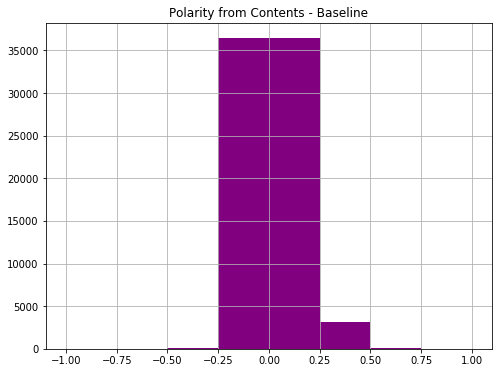

Text(0.5, 1.0, 'Subjectivity from Contents - Baseline')

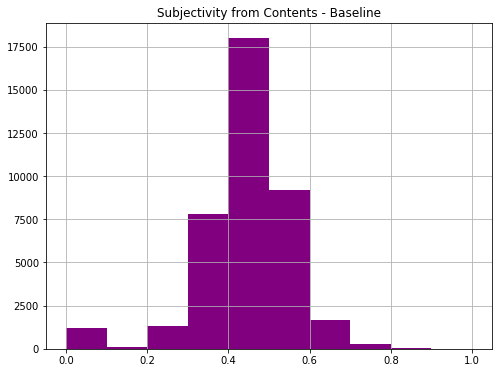

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
baseline[' global_sentiment_polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Polarity from Contents - Baseline")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the subjectivity values
baseline[' global_subjectivity'].hist(#bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],#0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             ax=ax,
             color="purple")

plt.title("Subjectivity from Contents - Baseline")
plt.show()

##### Sur les titres

Au niveau des titres, on a aussi une distribution de la polarité fortement concentrée autour de 0, et peu étalée. On a tout de même un peu plus de valeurs élevées (en valeur absolue) que pour le contenu. Selon nous, cela pourrait témoigner de la nécessité pour un titre d'être plus accrocheur, et de susciter plus d'émotions (positives ou négatives, tant qu'elles sont fortes) pour donner envie de cliquer.

Concernant le niveau de subjectivité des titres, c'est beaucoup plus étalé que pour les contenus. En effet, on retrouve un très grand nombre de valeurs nulles, qui témoignent à notre sens de la nécessité pour un titre d'être direct et universel, plutôt que soumis à l'opinion de celui qui l'écrit. Notons aussi que l'étalement pour le reste des classes et ici aussi plus élevé.

Text(0.5, 1.0, 'Polarity from Titles - Baseline')

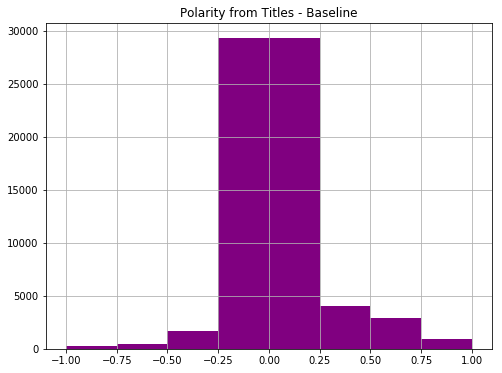

Text(0.5, 1.0, 'Subjectivity from Titles - Baseline')

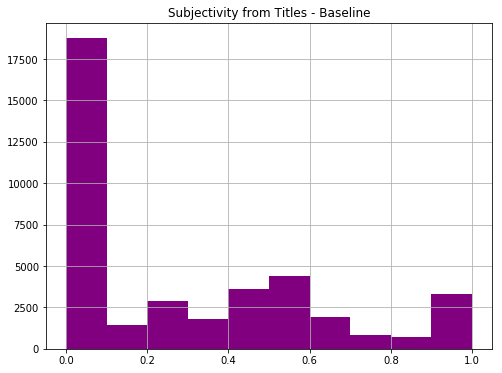

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
baseline[' title_sentiment_polarity'].hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Polarity from Titles - Baseline")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the subjectivity values
baseline[' title_subjectivity'].hist(#bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],#0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             ax=ax,
             color="purple")

plt.title("Subjectivity from Titles - Baseline")
plt.show()

## Sentiment analysis sur notre BDD scrappée

In [6]:
sp = spacy.load("en_core_web_lg")
merge_ents = sp.create_pipe("merge_entities")
sp.add_pipe(merge_ents)

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

add = ["mashable", "image", "courtesy", 'photo', "say"]
spacy_stopwords.update(add)

def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

def lemma(document, stopwords=spacy.lang.en.stop_words.STOP_WORDS, join=True):  
    
    select = [word.lemma_.lower() for word in sp(document) 
              if not hasNumbers(str(word.lemma_))
              and word.lemma_ not in ["-PRON-"] 
              and word.lemma_.lower() not in stopwords 
              and len(word.text) > 2]
    
    if join :
        serie_text = ','.join(select).replace(',', ' ')
        return serie_text
    else :
        return select

Au moment de conduire une analyse de sentiments, la question se pose quant au format des données sur lesquelles nous allons travailler : sur données lemmatisées ou non lemmatisées ? Il existe des arguments allant dans le sens de chacune de ces deux options :

- Lemmatiser les données : permet de simplifier notre analyse en réduisant le nombre total de mots à considérer, et donc en réduisant le bruit.
- Laisser les données telles quelles : la lemmatisation est une étape obligatoire pour de nombreuses tâches de NLP (e.g. topic modeling, word vectors). Cependant, dans une analyse de sentiments, la lemmatisation peut conduire à simplifier outre-mesure des mots et des phrases et donc à rater des éléments clefs qui nous auraient permis de mieux saisir et formaliser le sentiment du texte. Ceci est d'autant plus vrai lorsque le texte est de petite taille (titre d'un article par exemple).

Prenons un exemple. Deux phrases ne diffèrent que d'une seule lettre. Si on les lemmatise, on obtient la même phrase :

In [7]:
print('''"He hates brocoli" lemmatisé : ''' + lemma('He hates broccoli'))
print('''"He hates brocoli" lemmatisé : ''' + lemma('He hated broccoli'))

"He hates brocoli" lemmatisé : hate broccoli
"He hates brocoli" lemmatisé : hate broccoli


Ainsi, si on les lemmatise, les scores seront exactement les mêmes. Cependant, le score de polarité obtenu pour les deux phrases brutes est différent :

In [8]:
print("Score de polarité de la première forme (hates) : \n" + str(TextBlob('He hates broccoli').polarity))
print('\n')
print("Score de polarité de la seconde forme (hated) : \n" + str(TextBlob('He hated broccoli').polarity))

Score de polarité de la première forme (hates) : 
0.0


Score de polarité de la seconde forme (hated) : 
-0.9


La forme avec "hated" est jugée fortement négative, alors que celle avec "hates" neutre. Le choix de lemmatiser ou non les textes est donc susceptible de modifier nos résultats. Nous nous penchons ici sur ces deux options, et en retiendrons une seule au final.

## Textes non lemmatisés

La librairie TextBlob s'appuie sur deux modules pour conduire ses analyses de sentiments. D'abord, le module PatternAnalyzer (basé sur la librairie pattern), ou alors sur le module NaivesBayesAnalyzer (basé sur la librairie NLTK). Ce dernier ayant été entraîné sur une base de données de critiques de cinéma, nous utiliserons la première option (sélectionnée par défaut) qui est plus générale.

##### Sur le contenu

In [9]:
# Create textblob objects of the articles
sentiment_objects = [TextBlob(content) for content in df.content]
# Create list of polarity and subjectivity values
sentiment_values = [[content.polarity, content.subjectivity, str(content)] for content in sentiment_objects]
# Create dataframe containing the sentiment values and the contents
brut_content_sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "subjectivity", "content"], index=df.index)

brut_content_sentiment_df.head()

,polarity,subjectivity,content
0,0.148948,0.341246,The Associated Press is the latest news organ...
1,0.323333,0.702222,It looks like 2012 was a pretty good year for...
2,0.116975,0.421078,"When it comes to college football, NASA astro..."
3,0.285637,0.516378,LAS VEGAS — Sharing photos and videos on your...
4,0.071184,0.437409,LAS VEGAS — RC toys have traded in their bul...


Text(0.5, 1.0, 'Polarity from Contents - No lemmatization')

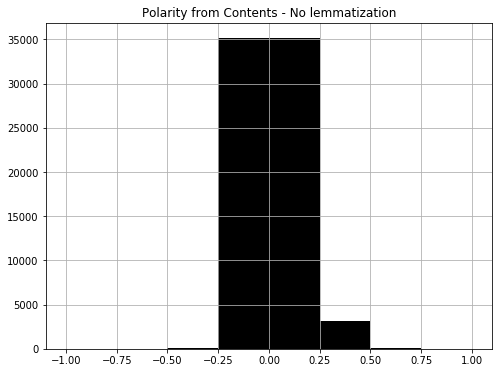

Text(0.5, 1.0, 'Subjectivity from Contents - No lemmatization')

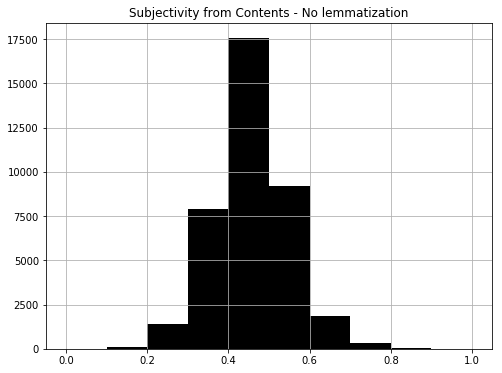

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
brut_content_sentiment_df.polarity.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="black")

plt.title("Polarity from Contents - No lemmatization")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the subjectivity values
brut_content_sentiment_df.subjectivity.hist(#bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             ax=ax,
             color="black")

plt.title("Subjectivity from Contents - No lemmatization")
plt.show()

##### Sur les titres

In [11]:
# Create textblob objects of the titles
sentiment_objects = [TextBlob(title) for title in df.title]
# Create list of polarity and subjectivity values
sentiment_values = [[title.polarity, title.subjectivity, str(title)] for title in sentiment_objects]
# Create dataframe containing the sentiment values and the titles
brut_title_sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "subjectivity", "title"], index=df.index)

brut_title_sentiment_df.head()

,polarity,subjectivity,title
0,0.000000,0.000000,AP's Twitter to Begin Displaying Sponsored Tweets
1,0.000000,0.000000,Apple's App Store Passes 40 Billion Downloads
2,0.000000,0.000000,This Astronaut Is Rooting for Notre Dame Tonight
3,0.136364,0.454545,New U-Verse Apps Simplify Sharing Photos and V...
4,0.214286,0.642857,BeeWi's Smart Toys Put Your Smartphone in Control


Text(0.5, 1.0, 'Polarity from Titles - No lemmatization')

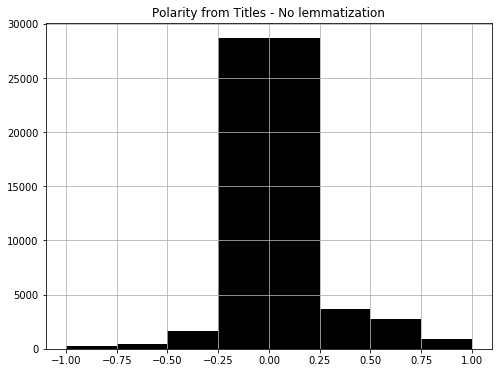

Text(0.5, 1.0, 'Subjectivity from Titles')

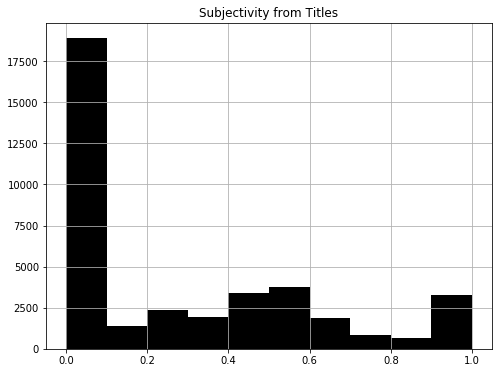

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
brut_title_sentiment_df.polarity.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="black")

plt.title("Polarity from Titles - No lemmatization")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the subjectivity values
brut_title_sentiment_df.subjectivity.hist(#bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             ax=ax,
             color="black")

plt.title("Subjectivity from Titles")
plt.show()

## Textes lemmatisés et sans stopwords

##### Sur le contenu

In [13]:
%%time

serie = df.content.apply(lambda x : lemma(x,spacy_stopwords))

Wall time: 1h 15min 11s


In [14]:
df['lemmatized_article'] = serie

In [15]:
# Create textblob objects of the articles
sentiment_objects = [TextBlob(content) for content in serie]

In [16]:
# Create list of polarity and subjectivity values
sentiment_values = [[content.polarity, content.subjectivity, str(content)] for content in sentiment_objects]
# Create dataframe containing the sentiment values and the contents
content_sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "subjectivity", "content"], index=df.index)

content_sentiment_df.head()

,polarity,subjectivity,content
0,0.111785,0.328788,the associated press late news organization ex...
1,0.245833,0.754861,look like a pretty good year apple app store a...
2,0.053358,0.411419,come college football nasa astronaut kevin for...
3,0.177059,0.505221,las vegas share video little easy at&t verse c...
4,0.075292,0.440638,las vegas toy trade bulky remote control gadge...


Du point de vue du contenu des articles, les données lemmatisées mènent à une distribution de la polarité très similaire à précédemment. En revanche, concernant la subjectivité, nous retrouvons des niveau plus élevés et plus présents dans la tranche 0.5-0.6 que pour les deux BDD précédentes.

Text(0.5, 1.0, 'Polarity from Contents')

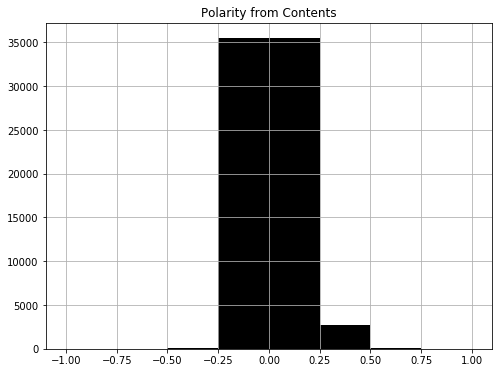

Text(0.5, 1.0, 'Subjectivity from Contents')

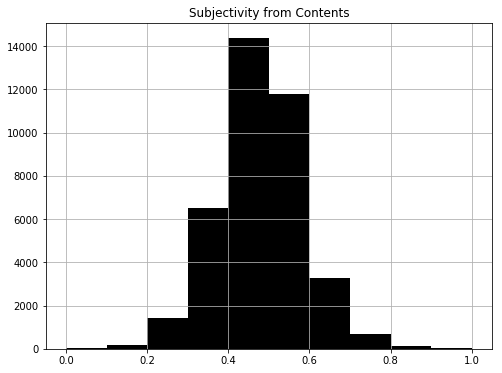

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
content_sentiment_df.polarity.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="black")

plt.title("Polarity from Contents")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the subjectivity values
content_sentiment_df.subjectivity.hist(#bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             ax=ax,
             color="black")

plt.title("Subjectivity from Contents")
plt.show()

##### Sur les titres

In [18]:
%%time

serie = df.title.apply(lambda x : lemma(x,spacy_stopwords))

Wall time: 4min 50s


In [19]:
# Create textblob objects of the titles
sentiment_objects = [TextBlob(title) for title in serie]
# Create list of polarity and subjectivity values
sentiment_values = [[title.polarity, title.subjectivity, str(title)] for title in sentiment_objects]
# Create dataframe containing the sentiment values and the titles
title_sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "subjectivity", "title"], index=df.index)

title_sentiment_df.head()

,polarity,subjectivity,title
0,0.000000,0.000000,twitter begin display sponsored tweet
1,0.000000,0.000000,apple app store pass billion download
2,0.000000,0.000000,astronaut root notre dame tonight
3,0.136364,0.454545,new u-verse apps simplify share photos videos
4,0.214286,0.642857,beewi smart toys smartphone control


Du côté des titres, on obtient une distribution de polarité encore une fois similaire, mais une distribution de la subjectivité un peu plus concentrée en 0.

Text(0.5, 1.0, 'Polarity from Titles')

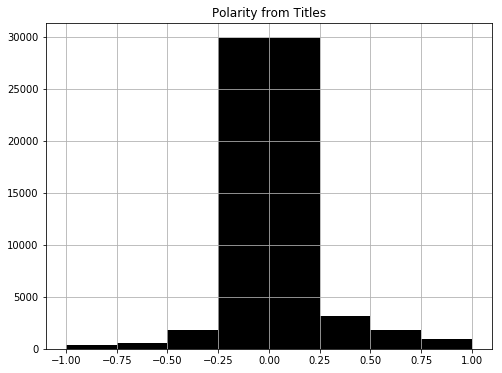

Text(0.5, 1.0, 'Subjectivity from Titles')

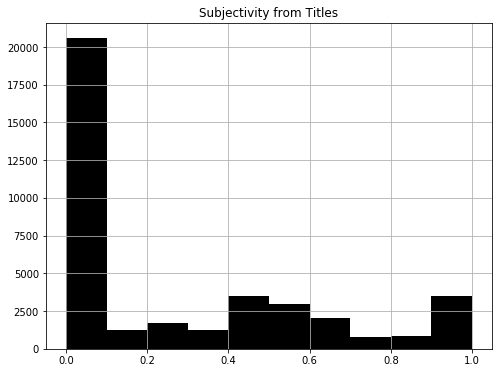

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
title_sentiment_df.polarity.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="black")

plt.title("Polarity from Titles")
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the subjectivity values
title_sentiment_df.subjectivity.hist(#bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
             ax=ax,
             color="black")

plt.title("Subjectivity from Titles")
plt.show()

Au final, on voit que les résultats d'analyse de sentiments sont relativement proches en distributions entre les trois BDD, bien que les différences se concentrent surtout en termes de subjectivité (plus importantes pour la lemmatisée dans le contenu, et plus faible dans les titres). Aussi, la distribution baseline se rapproche légèrement plus de la distribution des scores via textes bruts que via textes lemmatisés.

### Comparaison d'échantillons

In [21]:
### BDD initiale
baseline_content_polarity_df = pd.DataFrame(data={'url': baseline.url, 'title': baseline.titre, 'baseline': baseline[' global_sentiment_polarity']})
baseline_content_subjectivity_df =  pd.DataFrame(data={'url': baseline.url, 'title': baseline.titre, 'baseline': baseline[' global_subjectivity']})
baseline_title_polarity_df =  pd.DataFrame(data={'url': baseline.url, 'title': baseline.titre, 'baseline': baseline[' title_subjectivity']})                     
baseline_title_subjectivity_df =  pd.DataFrame(data={'url': baseline.url, 'title': baseline.titre, 'baseline': baseline[' title_sentiment_polarity']}) 
### BDD scrappée
content_polarity_df = pd.DataFrame(data={'url': df.url, 'title': df.title, 'brut': brut_content_sentiment_df.polarity, 'lemmatized':content_sentiment_df.polarity})
content_subjectivity_df =  pd.DataFrame(data={'url': df.url, 'title': df.title, 'brut': brut_content_sentiment_df.subjectivity, 'lemmatized':content_sentiment_df.subjectivity})
title_polarity_df =  pd.DataFrame(data={'url': df.url, 'title': df.title, 'brut': brut_title_sentiment_df.polarity, 'lemmatized':title_sentiment_df.polarity})                     
title_subjectivity_df =  pd.DataFrame(data={'url': df.url, 'title': df.title, 'brut': brut_title_sentiment_df.subjectivity, 'lemmatized':title_sentiment_df.subjectivity})

In [22]:
# Faire matcher les articles et comparer leurs scores
initiale = [baseline_content_polarity_df, baseline_content_subjectivity_df, baseline_title_polarity_df, baseline_title_subjectivity_df]
liste = [content_polarity_df, content_subjectivity_df, title_polarity_df, title_subjectivity_df]
merged = []

for ini, lst in zip(initiale, liste):
    merged.append(lst.merge(ini, how='inner', left_on=['url', 'title'], right_on=['url', 'title']))

#### Polarité du contenu

In [23]:
pol_cont = merged[0].sample(10)[['title', 'baseline', 'brut', 'lemmatized']]
print(pol_cont.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                                             title &  baseline &      brut &  lemmatized \\
\midrule
 TransAsia Plane Crashes in Taiwan, Killing Dozens &  0.129464 &  0.012626 &   -0.008508 \\
        The Ultimate Guide to the Best Summer Ever &  0.076035 &  0.284848 &    0.247917 \\
 Google's Contact Lens and Other News You Need ... &  0.120294 &  0.174762 &    0.305291 \\
   'Addams Family' actor Ken Weatherwax dead at 59 &  0.087268 &  0.047987 &    0.143142 \\
 Amazon Adds More Children's Shows in Expanded ... &  0.145105 &  0.166288 &    0.109479 \\
 'Wall-E' Inspires Dance Trio Above \& Beyond's ... &  0.038726 &  0.064332 &    0.039069 \\
       10 Incredibly Realistic Minecraft Creations &  0.090799 &  0.105303 &    0.061668 \\
 How to Check If Your Adobe Account Was Comprom... &  0.264569 &  0.228121 &    0.202443 \\
 'You've Been on Your Phone for 160 Minutes Today' &  0.119635 &  0.062731 &   -0.013867 \\
  Capture Art on the Walls for Our Phot

In [24]:
print('Ecart absolu moyen entre textes brutes et textes lemmatisés :')
print(mean_absolute_error(liste[0].brut, liste[0].lemmatized))
print("\n")
print("Ecart absolu moyen entre textes brutes et textes baseline :")
print(mean_absolute_error(merged[0].brut, merged[0].baseline))
print("\n")
print("Ecart absolu moyen entre textes lemmatisés et textes baseline :")
print(mean_absolute_error(merged[0].lemmatized, merged[0].baseline))

Ecart absolu moyen entre textes brutes et textes lemmatisés :
0.0473493720207589


Ecart absolu moyen entre textes brutes et textes baseline :
0.08495814757868952


Ecart absolu moyen entre textes lemmatisés et textes baseline :
0.10037842974435306


#### Subjectivité du contenu

In [25]:
subj_cont = merged[1].sample(10)[['title', 'baseline', 'brut', 'lemmatized']]
print(subj_cont.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                                             title &  baseline &      brut &  lemmatized \\
\midrule
  Simon \& Schuster Brings E-Books to NYC Libraries &  0.462294 &  0.462294 &    0.409933 \\
 Pebble to Announce ‘Something Special’ at CES ... &  0.513539 &  0.531210 &    0.490617 \\
               How the Internet saved 'Doctor Who' &  0.346146 &  0.431719 &    0.494119 \\
        Samsung to Unveil Galaxy Note 3 on Sept. 4 &  0.487143 &  0.339337 &    0.356126 \\
 48 Songs to Celebrate Seahawks' Super Bowl Vic... &  0.290306 &  0.564957 &    0.590547 \\
 Vining While Driving: The Deadly Trend Million... &  0.298810 &  0.540670 &    0.573449 \\
 Watch Keanu Reeves Dodge Fire in '47 Ronin' Tr... &  0.372222 &  0.443333 &    0.541667 \\
 March Madness Is the Most Emotional Sporting E... &  0.427560 &  0.426747 &    0.431210 \\
 Hyperactive Sun Fires Off 3 Major Solar Flares... &  0.544628 &  0.551701 &    0.610585 \\
 British Movie Villains Take Center Sta

In [26]:
print('Ecart absolu moyen entre textes brutes et textes lemmatisés :')
print(mean_absolute_error(liste[1].brut, liste[1].lemmatized))
print("\n")
print("Ecart absolu moyen entre textes brutes et textes baseline :")
print(mean_absolute_error(merged[1].brut, merged[1].baseline))
print("\n")
print("Ecart absolu moyen entre textes lemmatisés et textes baseline :")
print(mean_absolute_error(merged[1].lemmatized, merged[1].baseline))

Ecart absolu moyen entre textes brutes et textes lemmatisés :
0.04075113826432331


Ecart absolu moyen entre textes brutes et textes baseline :
0.09133671382932795


Ecart absolu moyen entre textes lemmatisés et textes baseline :
0.10654857327474974


#### Polarité des titres

In [27]:
pol_tit = merged[2].sample(10)[['title', 'baseline', 'brut', 'lemmatized']]
print(pol_tit.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                                             title &  baseline &      brut &  lemmatized \\
\midrule
    Google Introduces Tool to Calculate Mobile ROI &  0.000000 &  0.000000 &     0.00000 \\
 Little Girl Learns the Harsh Reality of Deleti... &  0.900000 & -0.193750 &    -0.19375 \\
              eBay Enlists Users to Fight Tax Plan &  0.000000 &  0.000000 &     0.00000 \\
                Should Your Company Be on Google+? &  0.416667 &  0.000000 &     0.00000 \\
 Artist imagines life as her mother's best frie... &  0.833333 &  0.925000 &     0.77500 \\
 Sony Brings Virtual-Reality System 'Project Mo... &  0.100000 &  0.000000 &     0.00000 \\
 Private land in Wyoming's national park is now... &  0.000000 &  0.000000 &     0.00000 \\
 Minecraft Maker Reports Stellar Earnings and T... &  0.312500 &  0.062500 &     0.25000 \\
 Too Many Errands? Someone Else Will Do Them fo... &  0.500000 &  0.500000 &     0.00000 \\
 How Much Is Yahoo Worth Without Alibaba

In [28]:
print('Ecart absolu moyen entre textes brutes et textes lemmatisés :')
print(mean_absolute_error(liste[2].brut, liste[2].lemmatized))
print("\n")
print("Ecart absolu moyen entre textes brutes et textes baseline :")
print(mean_absolute_error(merged[2].brut, merged[2].baseline))
print("\n")
print("Ecart absolu moyen entre textes lemmatisés et textes baseline :")
print(mean_absolute_error(merged[2].lemmatized, merged[2].baseline))

Ecart absolu moyen entre textes brutes et textes lemmatisés :
0.05484534301052659


Ecart absolu moyen entre textes brutes et textes baseline :
0.3187449265283056


Ecart absolu moyen entre textes lemmatisés et textes baseline :
0.3235351378256945


#### Subjectivité des titres

In [29]:
subj_tit = merged[3].sample(10)[['title', 'baseline', 'brut', 'lemmatized']]
print(subj_tit.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                                             title &  baseline &     brut &  lemmatized \\
\midrule
        15 Puppies That Understand Your Excitement &  0.000000 &  0.00000 &      0.0000 \\
 This Old Spice Ad Will Make You Empathize With... &  0.361905 &  0.20000 &      0.2000 \\
 Google Doodle Honors 50th Anniversary of 'I Ha... &  0.000000 &  0.00000 &      0.0000 \\
 Brain-Scanning Headphones Match Songs to Your ... &  0.000000 &  0.00000 &      0.0000 \\
 Redditors Accuse Popular Kickstarter Project o... & -0.025000 &  0.90000 &      0.9000 \\
 Follow the Honey: Can we Save the Bees by Trac... &  0.000000 &  0.00000 &      0.0000 \\
 Dramatic Scenes as Light Plane Crashes Into Ho... & -0.050000 &  0.65000 &      0.6500 \\
 Online Journalism Is Growing, But That Doesn't... &  0.150000 &  0.44375 &      0.6875 \\
 Apple Ad Campaign Highlights iPad Apps You've ... &  0.000000 &  0.00000 &      0.0000 \\
 Kevin Ware Dunks Months After His Horrific Inj...

In [30]:
print('Ecart absolu moyen entre textes brutes et textes lemmatisés :')
print(mean_absolute_error(liste[3].brut, liste[3].lemmatized))
print("\n")
print("Ecart absolu moyen entre textes brutes et textes baseline :")
print(mean_absolute_error(merged[3].brut, merged[3].baseline))
print("\n")
print("Ecart absolu moyen entre textes lemmatisés et textes baseline :")
print(mean_absolute_error(merged[3].lemmatized, merged[3].baseline))

Ecart absolu moyen entre textes brutes et textes lemmatisés :
0.0665735442327976


Ecart absolu moyen entre textes brutes et textes baseline :
0.3139778141828439


Ecart absolu moyen entre textes lemmatisés et textes baseline :
0.31516755737151736


On retrouve des écarts absolus moyens entre données brutes et lemmatisés situés autour de 0.05. Sur des échelles allant de -1 à 1, ou de 0 à 1, c'est un chiffre non négligeable.

Au niveau des écarts avec la baseline, on retrouve des écarts plus importants sur les titres (logique car il y a moins de variables pour construire un score) et des écarts légèrement plus faibles du texte brut par rapport à la baseline.

Afin de nous assurer des résultats les plus fiables possibles, et pour les raisons évoquées plus haut (avec l'exemple "hate"), nous décidons de garder les résultats obtenus sur textes bruts.

### Création de la BDD finale

In [31]:
df['content_polarity'] = brut_content_sentiment_df.polarity
df['abs_content_polarity'] = abs(brut_content_sentiment_df.polarity)
df['content_subjectivity'] = brut_content_sentiment_df.subjectivity
df['title_polarity'] = brut_title_sentiment_df.polarity
df['abs_title_polarity'] = abs(brut_title_sentiment_df.polarity)
df['title_subjectivity'] = brut_title_sentiment_df.subjectivity

In [32]:
df.to_csv("data_final.csv")